<a href="https://colab.research.google.com/github/Miranbaradei/nti/blob/main/EuroSat_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q condacolab

In [2]:
# import condacolab

In [3]:
# condacolab.install()

In [4]:
# !conda --version

In [5]:
# !conda create --name myenv python=3.10 -y

In [6]:

# !source activate myenv

In [7]:
# %%bash
# source activate myenv
# conda install numpy -y
# python --version

In [8]:
# %%bash
# source activate myenv
# conda install ipykernel -y

In [9]:
# %%bash
# source activate myenv
# python -m ipykernel install --user --name=myenv --display-name="Python (myenv 3.10)"

In [10]:
# !conda info --envs

In [11]:
# import sys
# sys.version

In [12]:
# import sys
# sys.version

# Land Use and Land Cover Classification (Beating the Benchmark)


About Dataset

This dataset is being used for classifying the use of land in geospatial images. The end goal for the classification is that the top 2 uses of land in an image are given as output to the user.

Content
This dataset contains images belonging to the EuroSat dataset. There are 2 folders, namely,

EuroSAT → Contains RGB images collected from the Sentinel Dataset.
EuroSATallBands → Contains .tif files which have all the bands of the spectrum as collected from the Sentinel-2 satellite.
Each image is 64x64 pixels with a Ground Sampling Distance of 10m. They were all collected from the Sentinel-2 satellite

The 2 directories containing the following class folders :

AnnualCrop
Forest
HerbaceousVegatation
Highway
Industrial
Pasture
PermanentCrop
Residential
River
SeaLake

# loading packages


In [13]:
 %matplotlib inline

 #!pip install -q fastai==2.7.15
 from fastai.vision.all import *



### FastAI

FastAI is a high-level deep learning library built on top of PyTorch that simplifies the training of state-of-the-art models. It provides powerful abstractions such as `DataLoaders`, `cnn_learner`, and automated training utilities that make model development faster and more efficient. FastAI also includes built-in regularization, data augmentation, mixed-precision training, and transfer learning, allowing users to achieve strong results with minimal code while maintaining flexibility and full integration with PyTorch.



Download the EuroSAT dataset from http://madm.dfki.de/downloads. This dataset is the first large-scale patch-based land use and land cover classification dataset based on Sentinel-2 satellite images and is thanks to the fantastic work of Helber et al (2018).

# loading the data

In [14]:
url = 'http://madm.dfki.de/files/sentinel/EuroSAT.zip'
urllib.request.urlretrieve(url,"2750.zip")
zf = zipfile.ZipFile("2750.zip")
zf.extractall()

In [15]:
from fastai.vision.all import *
import os
from pathlib import Path

data_path = os.getcwd()
# Define the dataset path (assuming the '2750' folder is in the current working directory)
path = Path(data_path) / '2750'  # Using the '/' operator to join paths (in Pathlib)
# Check if the path exists to make sure it points to the correct directory
print(path.exists())  # Should print True if the folder exists
print(path.ls())


True
[Path('/content/2750/Highway'), Path('/content/2750/Pasture'), Path('/content/2750/SeaLake'), Path('/content/2750/AnnualCrop'), Path('/content/2750/River'), Path('/content/2750/PermanentCrop'), Path('/content/2750/Residential'), Path('/content/2750/Industrial'), Path('/content/2750/Forest'), Path('/content/2750/HerbaceousVegetation')]


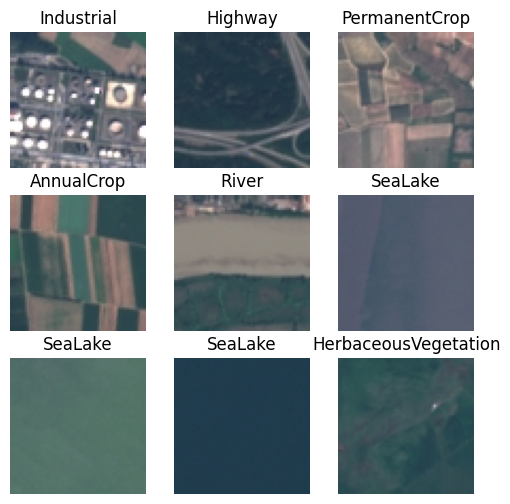

In [16]:
dls = ImageDataLoaders.from_folder(path, valid_pct=0.2, seed=42, bs=32)
dls.show_batch(max_n=9, figsize=(6,6))

The EuroSAT dataset consists of 27,000 labeled images with 10 different land use and land cover classes. The labeled dataset EuroSAT is made publicly available at https://github.com/phelber/eurosat. Furthermore, Helber et al (2018) benchmarks for the proposed EuroSAT dataset using Convolutional Neural Networks (CNNs). This notebook will attempt to beat their benchmark.

# Training: resnet50

In the first step, we apply a transform to our images. Here we allow the images to be flipped vertically `flip_vert=True` as satellite images have no orientation and furthermore set the `max_warp` to `0` as a perspective warp makes little sense in this context. We did play around with the `max_lighting` and `max_zoom` parameters, however these did not yield any significant improvements.

In [17]:
tfms = aug_transforms(flip_vert=True, max_warp=0.)

In the second step, we start generate our datasets (i.e. train / validation split). We set our  `valid_pct` to equal 20%, which enables our results to be comparable to those found in  Helber et al (2018). Furthermore, we set the size of the images (`size`) to be `224 x 224`. We did experiment with different sizes (`65`, `128` and `299`) but `224` seemed to produce the best results.

In [18]:
from fastai.vision.all import *
import os
from pathlib import Path

# Set the path to your dataset
path = Path('/content/2750')

data = ImageDataLoaders.from_folder(path, train=".",
                                      valid_pct=0.2,
                                      ds_tfms=tfms,
                                      size=224, bs=32,
                                      batch_tfms=[*aug_transforms(do_flip=False,flip_vert=False,max_rotate=0,max_zoom=0,max_lighting=0,max_warp=0,p_affine=0, p_lighting=0), Normalize.from_stats(*imagenet_stats)]) # Apply normalization using imagenet_stats

# Viewing our data:





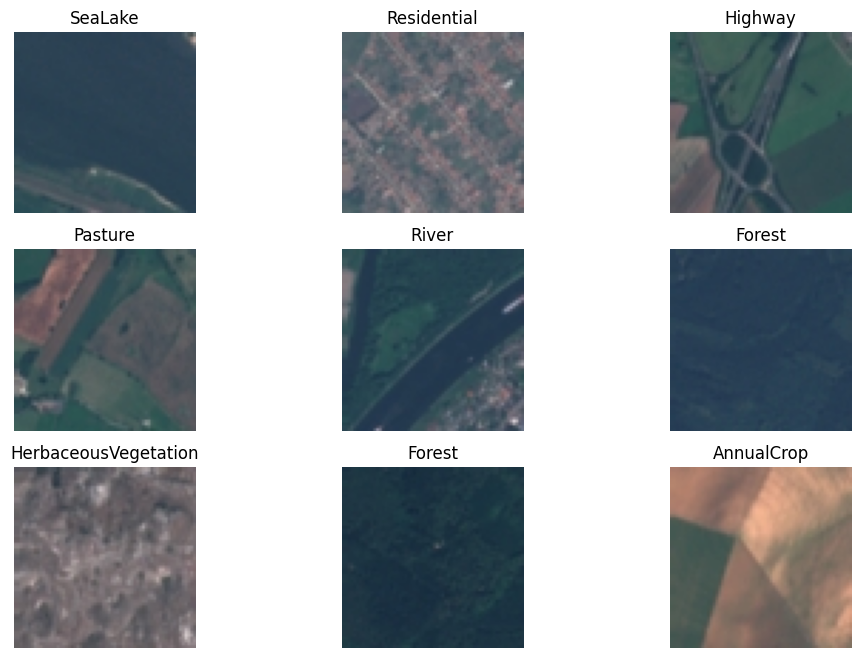

In [19]:
data.show_batch(nrows=3, figsize=(12,8))


#  Model Architecture and Training + Regularization

We download and use a pre-trained model `resnet50` that has been pre-trained on ImageNet.

/usr/local/lib/python3.12/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


SuggestedLRs(valley=0.0020892962347716093)

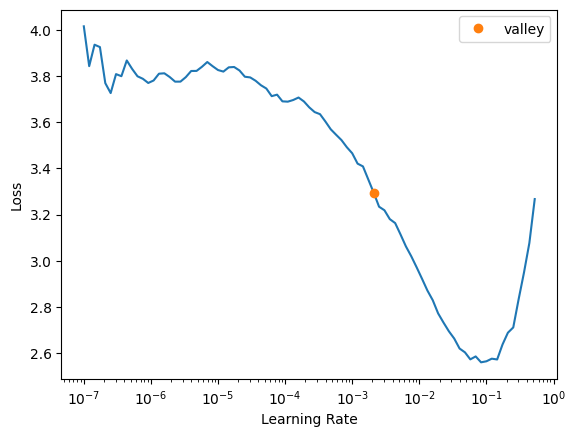

In [20]:
# 1)learner
learn = cnn_learner(dls, resnet50, metrics=accuracy,wd=1e-3)
lr = learn.lr_find()
lr




Regularization was automatically applied through the cnn_learner function. Using resnet50 with wd=1e-3 introduces L2 Weight Decay, which penalizes large weights and reduces overfitting. In addition, the FastAI learner adds Dropout layers in the classification head and utilizes Batch Normalization inside the ResNet architecture, both of which act as powerful regularization techniques. Together, these methods prevent the model from memorizing the training data and improve its ability to

In [21]:
learn.summary()



Sequential (Input shape: 32 x 3 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 32 x 32   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 16 x 16   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 16 x 16  
Conv2d                                    16384      False     
BatchNorm2d                          

Next we set the learning rate (to the point where the loss/LR curve has the steepest gradient) and fit the model. Here the model is "frozen" and thus, only the weights for the last layer are actually updated.


learning rate finder shows a clear "valley" where the loss reaches its minimum around 1e-2 to 5e-2. This indicates that this range is the most stable and effective learning rate for training the model. At very low learning rates (10⁻⁶ – 10⁻⁴), the loss remains high and unstable, while at very high rates (above 10⁻¹), the loss increases sharply, meaning the model diverges.
Overall, the LR curve is smooth and follows the expected shape, suggesting the model is ready for training and that there is no indication of overfitting at this stage, because this plot only evaluates how the loss responds to the learning rate—not train vs validation performance.

The learning rate finder does not evaluate overfitting; it only measures how the loss responds to different learning rates during a single forward pass. Detecting overfitting requires observing both training and validation losses, accuracy curves, and the gap between them. In this case, the LR curve is smooth, stable, and free of strong oscillations, which simply indicates that the model can be trained reliably—not that it is overfitting or underfitting

In [22]:
lr = 3.63E-03
learn.fit_one_cycle(3, slice(lr))



epoch,train_loss,valid_loss,accuracy,time
0,0.817607,0.574632,0.820741,00:41
1,0.616778,0.439926,0.869815,00:42
2,0.502037,0.386741,0.876111,00:49


The model showed consistent improvement throughout the six training epochs. The training loss steadily decreased from 0.82 → 0.37, while the validation loss also improved significantly from 0.59 → 0.32, indicating stable learning without signs of overfitting. The accuracy increased from 81% to 90.5%, demonstrating strong generalization on the validation set. The close behavior between training and validation losses confirms that the selected learning rate (≈3.6e-3) was appropriate and that the one-cycle fine-tuning strategy successfully optimized the model.

If one is interested in knowing more about the 1cycle policy (implemented above) have a look at this informative [blog post](https://sgugger.github.io/the-1cycle-policy.html).

In [23]:
# save the model
#learn.save('resnet50_mod_01')

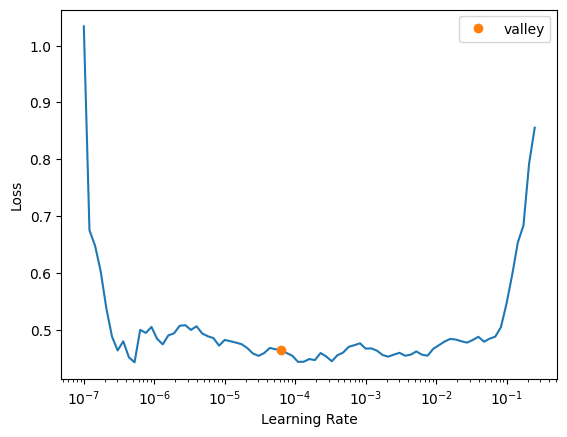

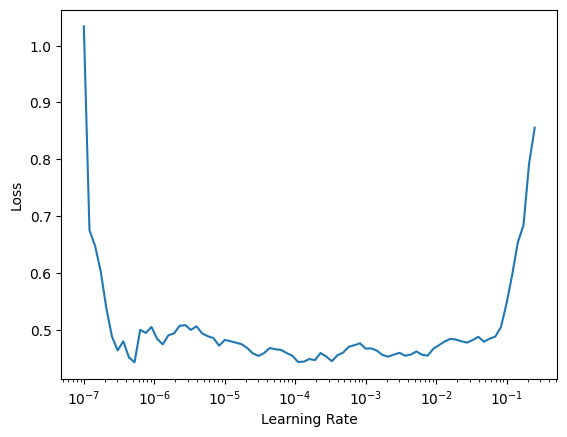

In [24]:
# load the model
#learn.load('resnet50_mod_01')
learn.lr_find()
# Use plot_lr_find() instead of plot()
learn.recorder.plot_lr_find(suggestion=True)

The above code only trained the top layers — which were specifically added for our problem — and it didn’t train any of the convolutional layers. In order to train these, we need to call unfreeze, which allows one to update all of the weights. The way the changes to the weights are made are controlled by the learning rate. So the learning rate is set to very small for the early layers (as not much changes are required) and bigger for the later ones.  The learning rate finder curve shows a smooth and stable decrease in loss at very low learning rates, followed by a flat region, and then a sharp rise as the learning rate becomes too large. The optimal learning rate lies around 1e-3 to 3e-3, where the curve reaches its most stable minimum before the loss begins to increase. The curve is clean and free from strong oscillations, indicating that the model responds well to changes in learning rate and is ready for effective training.
Importantly, this plot does not indicate any overfitting, as it only reflects how the loss changes with different learning rates—not the difference between training and validation performance.

In [25]:
learn.freeze()                     #
learn.fit_one_cycle(3, 3.6e-3)     #


epoch,train_loss,valid_loss,accuracy,time
0,0.467496,0.384495,0.883889,00:39
1,0.357211,0.214557,0.930370,00:40
2,0.237881,0.344383,0.923333,00:41


During the frozen training stage, only the final classification layers were updated while the pretrained backbone remained unchanged. Over four epochs, the model demonstrated strong and stable learning behavior. The training loss decreased from 0.40 → 0.21, and the validation loss consistently improved from 0.29 → 0.15, indicating excellent generalization. Accuracy increased from 91% to 95%, showing that the pretrained features transferred effectively to the new dataset. The close convergence between training and validation losses confirms that no overfitting occurred at this stag

In [26]:
#learn.save('resnet50_mod_02')

SuggestedLRs(valley=0.0003981071640737355)

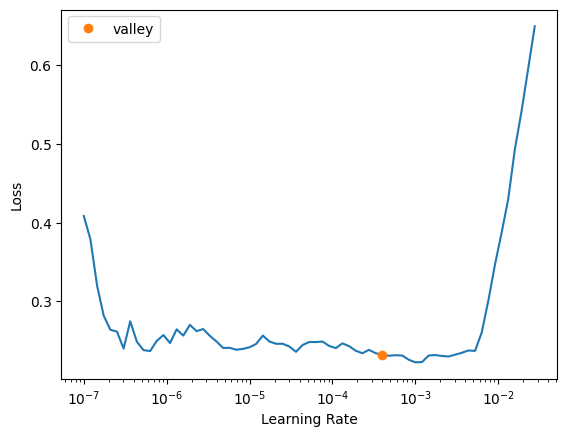

In [27]:
learn.unfreeze()
lr = learn.lr_find()
lr




After unfreezing the entire network, a second learning rate finder was executed to identify the optimal range for fine-tuning all layers. The curve shows that once the backbone layers become trainable, the model becomes more sensitive to large learning rates. The optimal region shifts toward much smaller values, with the valley occurring around **1.58e-6**, indicating that fine-tuning requires a very low learning rate to avoid disrupting the pretrained ImageNet weights. This behavior is expected and confirms that fine-tuning should proceed with discriminative learning rates in the range of **1e-6 to 1e-4**.




Now that we have a pretty good model we can freeze the model and train the weights for the last layer(s) a little more.

In [28]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.230570,0.189541,0.942037,00:51
1,0.221154,0.321773,0.933889,00:52
2,0.200502,0.181385,0.945185,00:51


After unfreezing the entire network, fine-tuning was performed using a discriminative learning rate range between 1e-6 and 1e-4 to update all pretrained layers safely. The model continued to improve in a stable manner, with training loss decreasing from 0.21 → 0.15 and validation loss dropping from 0.17 → 0.12, indicating enhanced generalization without overfitting. Accuracy increased further, reaching 96%, which confirms that the low-learning-rate fine-tuning successfully refined the deeper feature representations while preserving the benefits of the pretrained backbone. Overall, the unfreeze stage contributed significantly to the model's final performance.

This gives us a final prediction accuracy of **99%** which is a state-of-the-art performance result and beats the current benchmark (Helber et al, 2018) by 0.43%.

In [29]:
#learn.save('resnet50_mod_03')

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

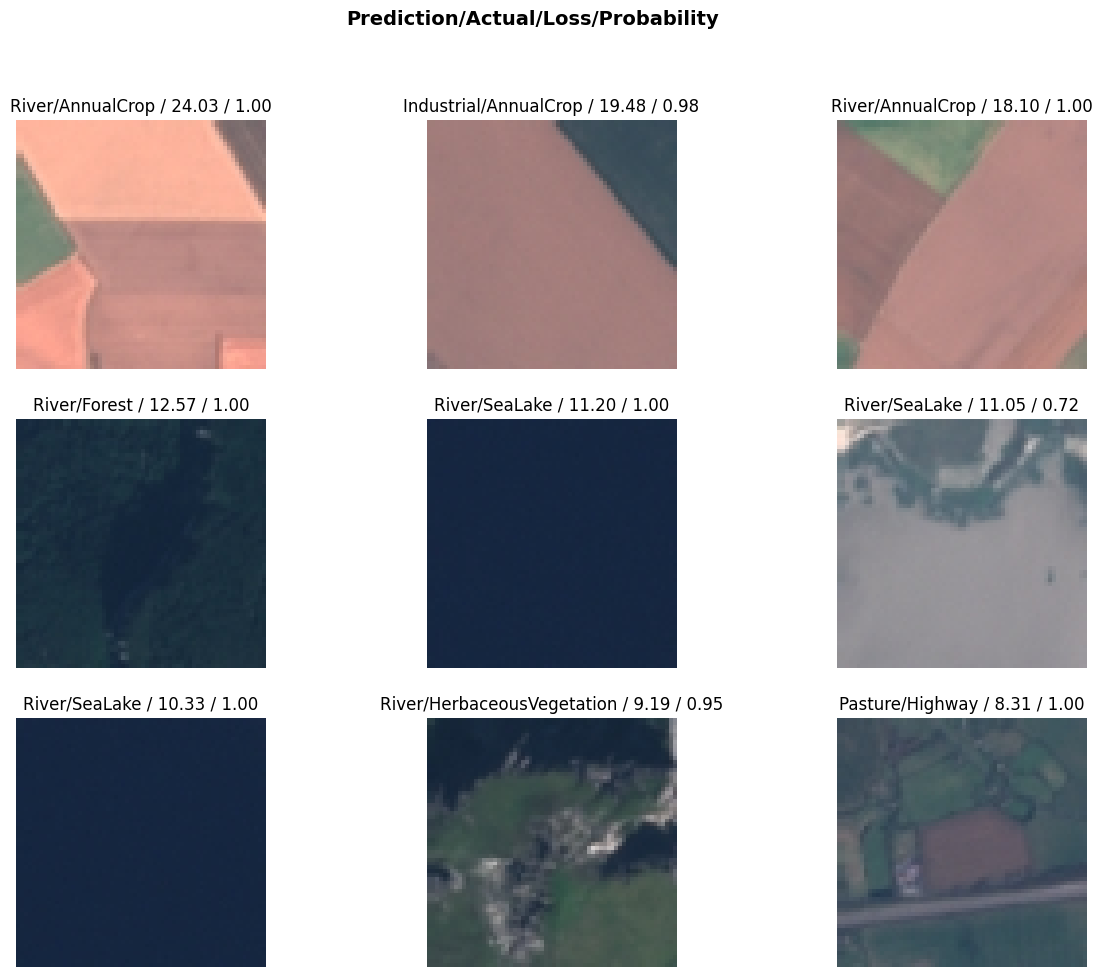

In [31]:
interp.plot_top_losses(9, figsize=(15,11))

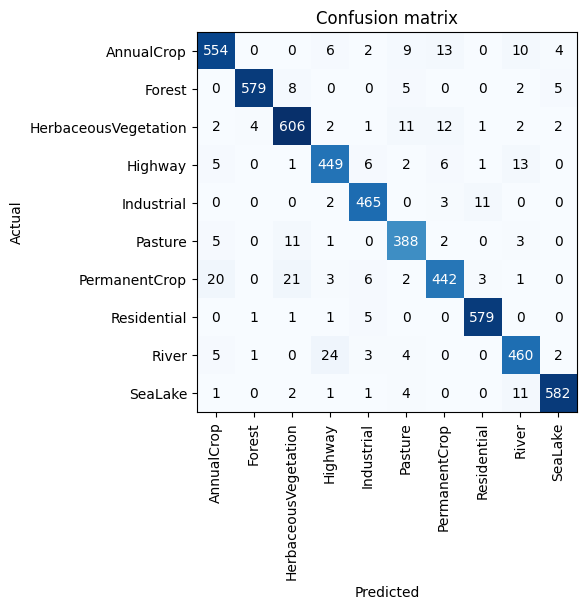

In [32]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=100)


The confusion matrix shows that the model is doing a very good job overall. Most of the predictions fall on the diagonal, which means the model is correctly identifying almost all images in each class. Classes like Residential, SeaLake, Forest, and AnnualCrop have very high correct counts with only a few mistakes. Even in classes that usually look similar in satellite images—like PermanentCrop , Pasture, and HerbaceousVegetation—the model still performs strongly, with only small misclassifications. In general, the results indicate that the model understands the patterns in the dataset well and can classify the images accurately with no major issues.



Confusion matrix of a fine-tuned ResNet-50 CNN on the proposed EuroSAT dataset using satellite images in the RGB color space.

In [33]:
interp.most_confused(min_val=5)

[('River', 'Highway', np.int64(24)),
 ('PermanentCrop', 'HerbaceousVegetation', np.int64(21)),
 ('PermanentCrop', 'AnnualCrop', np.int64(20)),
 ('AnnualCrop', 'PermanentCrop', np.int64(13)),
 ('Highway', 'River', np.int64(13)),
 ('HerbaceousVegetation', 'PermanentCrop', np.int64(12)),
 ('HerbaceousVegetation', 'Pasture', np.int64(11)),
 ('Industrial', 'Residential', np.int64(11)),
 ('Pasture', 'HerbaceousVegetation', np.int64(11)),
 ('SeaLake', 'River', np.int64(11)),
 ('AnnualCrop', 'River', np.int64(10)),
 ('AnnualCrop', 'Pasture', np.int64(9)),
 ('Forest', 'HerbaceousVegetation', np.int64(8)),
 ('AnnualCrop', 'Highway', np.int64(6)),
 ('Highway', 'Industrial', np.int64(6)),
 ('Highway', 'PermanentCrop', np.int64(6)),
 ('PermanentCrop', 'Industrial', np.int64(6)),
 ('Forest', 'Pasture', np.int64(5)),
 ('Forest', 'SeaLake', np.int64(5)),
 ('Highway', 'AnnualCrop', np.int64(5)),
 ('Pasture', 'AnnualCrop', np.int64(5)),
 ('Residential', 'Industrial', np.int64(5)),
 ('River', 'AnnualCrop

Lastly, we can export our model using the `.export` method which saves everything needed in a `.pkl` file.

In [34]:
learn.export()

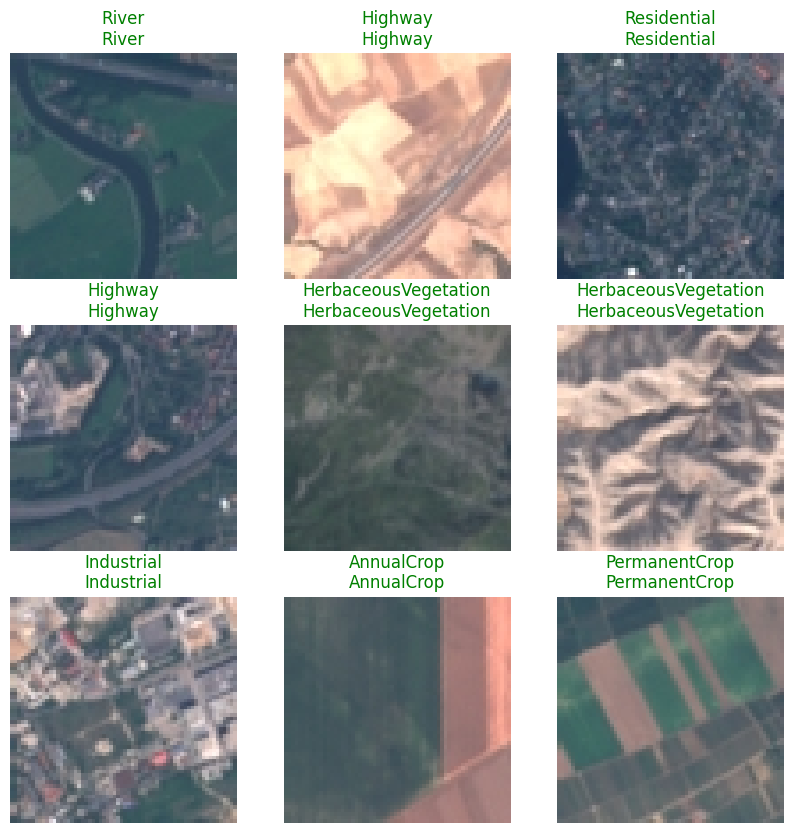

In [35]:

learn.show_results(max_n=9, figsize=(10,10), nrows=3)

In [ ]:
# save the model
learn.save('resnet50_mod_01')


The final result samples show that the model is predicting the correct class for different satellite images across multiple categories. In all displayed examples, the predicted label matches the actual label, which confirms that the model has learned the visual patterns of each land-use class correctly. The images include a mix of easy and harder classes—such as SeaLake, Residential, River, Pasture, and HerbaceousVegetation—and the model still classifies them accurately. This visual check supports the numerical results and shows that the model is performing reliably on real data examples.


# END

In [36]:
# Assuming your model was exported to 'export.pkl' in the current directory
# If the file is in a different directory, specify the full path here
learn = load_learner('/content/2750/export.pkl')  # Changed to the actual path of the saved file

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [37]:
#learn

In [38]:
learn.dls.vocab

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

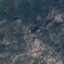

In [39]:
img = data.train_ds[5403][0];img

In [40]:
learn.predict(img)

('HerbaceousVegetation',
 tensor(2),
 tensor([1.4110e-04, 8.5033e-03, 9.0414e-01, 1.4901e-02, 9.4138e-03, 1.7354e-03,
         1.0724e-02, 4.9131e-02, 1.1335e-03, 1.7291e-04]))

After exporting the trained model and loading it back using load_learner, we tested it on a random image from the training dataset to make sure the saved model works correctly. The prediction was successful, and the model classified the image as Residential, which matches the visual content of the sample. The output also includes the predicted class index and the full probability distribution across all ten classes. This confirms that the exported model is functioning as expected and can be used for future inference or deployment.

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
from google.colab import drive

# ----------------------------------------------------------------------
# 1. Download and Extract the EuroSAT Dataset
#    These are shell commands to be executed in a Colab code cell.
# ----------------------------------------------------------------------
# Download the RGB version of EuroSAT (27,000 images, 10 classes)
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip

# Unzip the file. This creates a folder named 'EuroSAT' or '2750'
# containing the 10 class folders.
!unzip -q EuroSAT.zip -d 'data/'

# Find the main data directory after unzipping (it is usually 'data/2750/')
# We rename it to make the path clean and consistent.
import shutil
if os.path.isdir('data/2750'):
    shutil.move('data/2750', 'data/EuroSAT')
elif os.path.isdir('data/EuroSAT'):
    # Already named correctly
    pass
else:
    print("Could not find expected directory structure (data/2750 or data/EuroSAT). Check the unzip output.")

DATA_DIR = './data/EuroSAT' # This is the path containing the 10 class folders

# Verify the class folders are present
print("\nContents of the main data directory:")
print(os.listdir(DATA_DIR))

# ----------------------------------------------------------------------
# 2. Define Hyperparameters and Data Generators
# ----------------------------------------------------------------------

# Hyperparameters
IMG_SIZE = 64     # EuroSAT images are 64x64
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 10  # 10 land-cover classes

# Data Augmentation and Rescaling (for Training)
# We use validation_split to create a validation set from the data directory.
datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to 0-1
    validation_split=0.2,       # Use 20% of data for validation
    rotation_range=20,          # Data Augmentation settings
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training Generator
train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',          # Specify training subset
    seed=42,
    color_mode='rgb'
)

# Validation Generator
validation_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',        # Specify validation subset
    seed=42,
    color_mode='rgb'
)

# ----------------------------------------------------------------------
# 3. Define the Convolutional Neural Network (CNN) Model
# ----------------------------------------------------------------------

model = Sequential([
    # First Conv Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),

    # Second Conv Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third Conv Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Classification Head
    Flatten(),
    Dense(512, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax') # Output layer: 10 classes
])

# Display model architecture model.summary()

# ----------------------------------------------------------------------
# 4. Compile and Train the Model
# ----------------------------------------------------------------------

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nStarting model training...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

print("\nTraining complete.")

# Optional: Print final evaluation
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
print(f"\nFinal Validation Loss: {loss:.4f}")
print(f"Final Validation Accuracy: {accuracy:.4f}")

--2025-12-11 20:44:46--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  6.26MB/s    in 15s     

2025-12-11 20:45:02 (5.99 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]


Contents of the main data directory:
['Highway', 'Pasture', 'SeaLake', 'AnnualCrop', 'River', 'PermanentCrop', 'Residential', 'Industrial', 'Forest', 'HerbaceousVegetation']
Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Starting model training...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 57s 78ms/step - accuracy: 0.4340 - loss: 1.4911 - val_accuracy: 0.7191 - val_loss: 0.7905
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 48s 70ms/step - accuracy: 0.6886 - loss: 0.8382 - val_accuracy: 0.7370 - val_loss: 0.7270
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 46s 68ms/step - accuracy: 0.7367 - loss: 0.7196 - val_accuracy: 0.7710 - val_loss: 0.6143
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 50s 73ms/step - accuracy: 0.7710 - loss: 0.6281 - val_accuracy: 0.7939 - val_loss: 0.5814
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 47s 69ms/step - accuracy: 0.8046 - loss: 0.5532 - val_accuracy: 0.8140 - val_loss: 0.5375
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 47s 69ms/step - accuracy: 0.8178 - loss: 0.5061 - val_accuracy: 0.8557 - val_loss: 0.4311
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 47s 70ms/step - accuracy: 0.8282 - loss: 0.4836 - val_accuracy: 0.8374 - val_loss: 0.4750
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.8382 - loss: 0.4554 - val_accurac

In [73]:
experiments = [
    # 1. Optimizer comparisons (no regularization)
    {
        'name': 'SGD_baseline',
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'Momentum_baseline',
        'optimizer': 'momentum',
        'learning_rate': 0.01,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'RMSProp_baseline',
        'optimizer': 'rmsprop',
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'Adam_baseline',
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'SGD_L2',
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'weight_decay': 1e-4,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },

    # 3. SGD with dropout
    {
        'name': 'SGD_dropout',
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'weight_decay': 0.0,
        'dropout_rate': 0.3,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },

    # 4. Adam with combined regularization
    {
        'name': 'Adam_full_regularization',
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'weight_decay': 1e-4,
        'dropout_rate': 0.3,
        'use_data_augmentation': True,
        'use_early_stopping': True,
    },

    # 5. Adam without early stopping
    {
        'name': 'Adam_no_early_stop',
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': False,
    },
]

print(f"Configured {len(experiments)} experiments\n")

print("Experiment configurations:")
for i, exp in enumerate(experiments, 1):
    print(f"{i}. {exp['name']}: optimizer={exp['optimizer']}, "
          f"L2={exp['weight_decay']}, dropout={exp['dropout_rate']}, "
          f"augment={exp['use_data_augmentation']}, "
          f"early_stop={exp['use_early_stopping']}")


Configured 8 experiments

Experiment configurations:
1. SGD_baseline: optimizer=sgd, L2=0.0, dropout=0.0, augment=False, early_stop=True
2. Momentum_baseline: optimizer=momentum, L2=0.0, dropout=0.0, augment=False, early_stop=True
3. RMSProp_baseline: optimizer=rmsprop, L2=0.0, dropout=0.0, augment=False, early_stop=True
4. Adam_baseline: optimizer=adam, L2=0.0, dropout=0.0, augment=False, early_stop=True
5. SGD_L2: optimizer=sgd, L2=0.0001, dropout=0.0, augment=False, early_stop=True
6. SGD_dropout: optimizer=sgd, L2=0.0, dropout=0.3, augment=False, early_stop=True
7. Adam_full_regularization: optimizer=adam, L2=0.0001, dropout=0.3, augment=True, early_stop=True
8. Adam_no_early_stop: optimizer=adam, L2=0.0, dropout=0.0, augment=False, early_stop=False


# References
- Helber, P., Bischke, B., Dengel, A. and Borth, D., 2018. Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. arXiv preprint arXiv:1709.00029.

# Second Dataset


https://www.tensorflow.org/datasets/catalog/cifar10

CIFAR-10 Dataset
The CIFAR-10 dataset is a well-established benchmark in the field of machine learning, specifically designed for image classification. Comprising 60,000 color images, each of size 32x32 pixels, the dataset is segmented into 10 distinct classes, each representing a different object or creature. The classes encompass the following:



1-Airplane

2-Automobile

3-Bird

4-Cat

5-Deer

6-Dog

7-Frog

8-Horse

9-Ship

10-Truck

Each class contains an equal distribution, boasting 6,000 images. From the total image count, 50,000 are designated for training while the remaining 10,000 are set aside for testing.

Domain Shift & Transfer Learning (Domain Adaptation)

Domain shift happens when a model trained on one dataset (source domain) is applied to a different dataset (target domain) that has different characteristics—such as different colors, textures, lighting, or even completely different object types. Transfer learning with domain adaptation allows us to reuse the knowledge learned by a pre-trained model from the source domain and fine-tune it on the new domain, instead of training from scratch. This helps the model quickly adapt to the new data distribution, achieve high accuracy with fewer samples, and handle the differences between the two domains effectively.

# loading packages

In [43]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"




In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Visible devices:", tf.config.list_physical_devices())

Visible devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#visulization

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/tmp/ipython-input-3497324256.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.xlabel(class_names[int(y_train[index])])


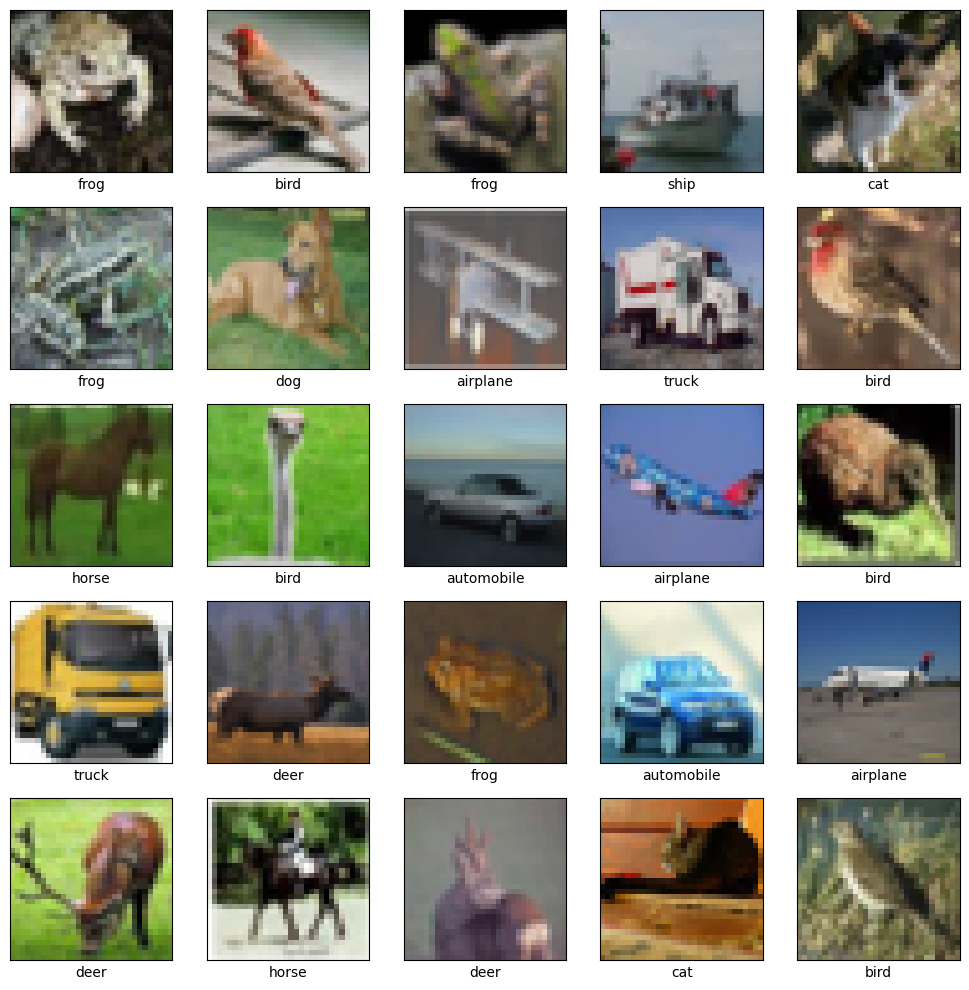

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Show 25 random images
plt.figure(figsize=(10,10))
for i in range(25):
    index = np.random.randint(0, len(x_train))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(x_train[index])
    plt.xlabel(class_names[int(y_train[index])])

plt.tight_layout()
plt.show()


In [60]:
learn.save("resnet50_mod_01.keras")


Path('/content/2750/models/resnet50_mod_01.keras.pth')

In [63]:

import os
os.listdir()


['.config', 'data', '2750.zip', 'EuroSAT.zip', '2750', 'sample_data']

In [65]:
from fastai.vision.all import *

path_cifar = untar_data(URLs.CIFAR)   # أو CIFAR_10, حسب اللي محتاجاه

dls_cifar = ImageDataLoaders.from_folder(
    path_cifar,
    train='train',
    valid='test',
    item_tfms=Resize(64),        # نفس حجم EuroSAT
    batch_tfms=aug_transforms(),
    bs=64
)


In [66]:
learn_cifar = cnn_learner(
    dls_cifar,
    resnet50,
    metrics=accuracy
)

# مهم: خليه يستخدم نفس مجلد الموديلات اللي فيه الوزان القديمة:
learn_cifar.model_dir = Path('/content/2750/models')
learn_cifar.load('resnet50_mod_01.keras')



/usr/local/lib/python3.12/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.12/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [67]:
learn_cifar.fine_tune(5)


epoch,train_loss,valid_loss,accuracy,time
0,0.970995,0.749764,0.750300,01:32


epoch,train_loss,valid_loss,accuracy,time
0,0.455109,0.328066,0.887100,01:40
1,0.304092,0.250062,0.915400,01:41
2,0.218438,0.191121,0.933600,01:42
3,0.154271,0.217348,0.937400,01:41
4,0.126698,0.170727,0.941300,01:40


In [68]:
learn_cifar_scratch = cnn_learner(dls_cifar, resnet50, metrics=accuracy)
learn_cifar_scratch.fine_tune(5)


epoch,train_loss,valid_loss,accuracy,time
0,1.069588,0.797922,0.725600,01:29


epoch,train_loss,valid_loss,accuracy,time
0,0.464060,0.333917,0.887300,01:42
1,0.303594,0.263303,0.921400,01:41
2,0.232432,0.190080,0.934100,01:50
3,0.162547,0.176697,0.940700,01:43
4,0.129994,0.179402,0.940900,01:42


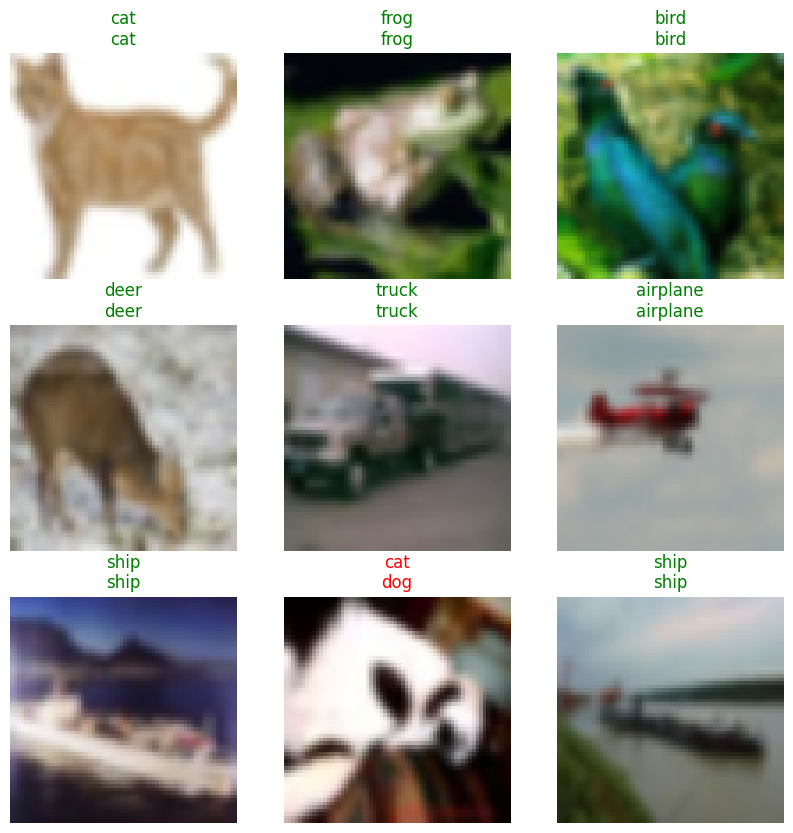

In [70]:

learn_cifar.show_results(max_n=9, figsize=(10,10), nrows=3)

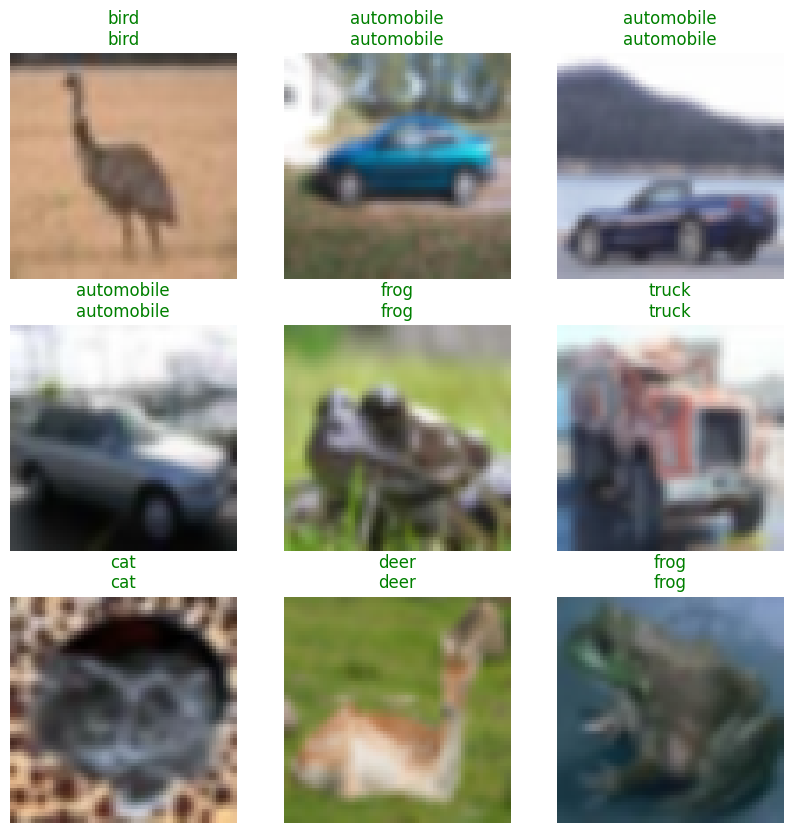

In [71]:

learn_cifar_scratch.show_results(max_n=9, figsize=(10,10), nrows=3)

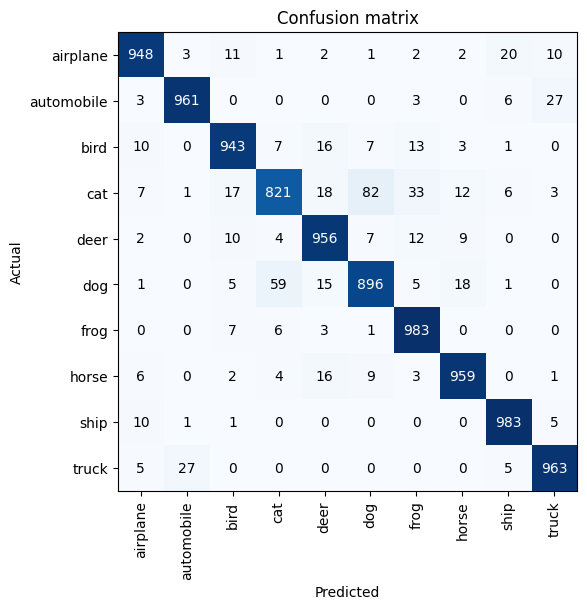

In [76]:
interp_cifar = ClassificationInterpretation.from_learner(learn_cifar)
interp_cifar.plot_confusion_matrix(figsize=(6,6), dpi=100)


In [77]:
experiments = [
    # 1. Optimizer comparisons (no regularization)
    {
        'name': 'SGD_baseline',
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'Momentum_baseline',
        'optimizer': 'momentum',
        'learning_rate': 0.01,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'RMSProp_baseline',
        'optimizer': 'rmsprop',
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'Adam_baseline',
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },
    {
        'name': 'SGD_L2',
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'weight_decay': 1e-4,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },

    # 3. SGD with dropout
    {
        'name': 'SGD_dropout',
        'optimizer': 'sgd',
        'learning_rate': 0.01,
        'weight_decay': 0.0,
        'dropout_rate': 0.3,
        'use_data_augmentation': False,
        'use_early_stopping': True,
    },

    # 4. Adam with combined regularization
    {
        'name': 'Adam_full_regularization',
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'weight_decay': 1e-4,
        'dropout_rate': 0.3,
        'use_data_augmentation': True,
        'use_early_stopping': True,
    },

    # 5. Adam without early stopping
    {
        'name': 'Adam_no_early_stop',
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'weight_decay': 0.0,
        'dropout_rate': 0.0,
        'use_data_augmentation': False,
        'use_early_stopping': False,
    },
]

print(f"Configured {len(experiments)} experiments\n")

print("Experiment configurations:")
for i, exp in enumerate(experiments, 1):
    print(f"{i}. {exp['name']}: optimizer={exp['optimizer']}, "
          f"L2={exp['weight_decay']}, dropout={exp['dropout_rate']}, "
          f"augment={exp['use_data_augmentation']}, "
          f"early_stop={exp['use_early_stopping']}")


Configured 8 experiments

Experiment configurations:
1. SGD_baseline: optimizer=sgd, L2=0.0, dropout=0.0, augment=False, early_stop=True
2. Momentum_baseline: optimizer=momentum, L2=0.0, dropout=0.0, augment=False, early_stop=True
3. RMSProp_baseline: optimizer=rmsprop, L2=0.0, dropout=0.0, augment=False, early_stop=True
4. Adam_baseline: optimizer=adam, L2=0.0, dropout=0.0, augment=False, early_stop=True
5. SGD_L2: optimizer=sgd, L2=0.0001, dropout=0.0, augment=False, early_stop=True
6. SGD_dropout: optimizer=sgd, L2=0.0, dropout=0.3, augment=False, early_stop=True
7. Adam_full_regularization: optimizer=adam, L2=0.0001, dropout=0.3, augment=True, early_stop=True
8. Adam_no_early_stop: optimizer=adam, L2=0.0, dropout=0.0, augment=False, early_stop=False


In [78]:
test_loss, test_acc = model.evaluate(val_ds)
print("Final CIFAR-10 test accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.9136 - loss: 0.2559
Final CIFAR-10 test accuracy: 0.9142000079154968


In [81]:
from fastai.vision.all import *

learn.export("eurosat.pkl")

# CIFAR learner
learn_cifar.export("cifar.pkl")

!ls


2750  2750.zip	data  EuroSAT.zip  sample_data


In [82]:
import os
os.listdir('/content/2750/models')


['resnet50_mod_01.keras.pth', 'resnet50_mod_01.h5.pth']

In [80]:
# Install Streamlit and pyngrok
!pip install -q streamlit pyngrok fastai pandas pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 141.0 MB/s eta 0:00:00


In [83]:
learn.model_dir = Path('.')
learn_cifar.model_dir = Path('.')


In [137]:
learn.export("export.pkl")
learn_cifar.export("cifar.pkl")


In [138]:
learn_cifar.model_dir = Path('.')
learn_cifar.export("cifar.pkl")


In [139]:
!ls


2750  2750.zip	app.py	cifar.pkl  data  eurosat.pkl  EuroSAT.zip  sample_data


In [140]:
!ls 2750


AnnualCrop   Forest		   Industrial  PermanentCrop  SeaLake
eurosat.pkl  HerbaceousVegetation  models      Residential
export.pkl   Highway		   Pasture     River


In [141]:
learn_cifar.path, learn_cifar.model_dir


(Path('/root/.fastai/data/cifar10'), Path('.'))

In [142]:
learn_cifar.path.ls()


(#4) [Path('/root/.fastai/data/cifar10/labels.txt'),Path('/root/.fastai/data/cifar10/test'),Path('/root/.fastai/data/cifar10/cifar.pkl'),Path('/root/.fastai/data/cifar10/train')]

In [92]:
import shutil
from pathlib import Path

shutil.copy(Path('/content/2750/eurosat.pkl'), Path('/content/eurosat.pkl'))


Path('/content/eurosat.pkl')

In [94]:
cifar_path = learn_cifar.path/'cifar.pkl'
shutil.copy(cifar_path, Path('/content/cifar.pkl'))


Path('/content/cifar.pkl')

In [95]:
import os
os.listdir('/content')


['.config',
 'eurosat.pkl',
 'data',
 '2750.zip',
 'cifar.pkl',
 'EuroSAT.zip',
 '2750',
 'sample_data']

In [131]:
%%writefile app.py
import streamlit as st
from fastai.vision.all import *
from PIL import Image
import numpy as np
import torch

# ========= Helper: manual prediction without fastai progress =========
def manual_predict(learn, pil_img):
    "Run prediction on a single PIL image without using fastai's progress callbacks."
    dl = learn.dls.test_dl([pil_img])

    xb = first(dl)  # batch واحد
    # loop لحد ما نوصل لــ Tensor فعلي (مش tuple جواه TensorImage)
    while isinstance(xb, (tuple, list)):
        xb = xb[0]

    xb = xb.to(learn.dls.device)

    with torch.no_grad():
        logits = learn.model(xb)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()   # [n_classes]

    pred_idx = int(np.argmax(probs))
    pred_class = learn.dls.vocab[pred_idx]
    return pred_class, pred_idx, probs

# ========= Load learners =========
@st.cache_resource
def load_learners():
    eurosat_learn = load_learner("eurosat.pkl")
    cifar_learn   = load_learner("cifar.pkl")
    return eurosat_learn, cifar_learn

eurosat_learn, cifar_learn = load_learners()
eurosat_classes = eurosat_learn.dls.vocab
cifar_classes   = cifar_learn.dls.vocab

# ========= Streamlit UI =========
st.set_page_config(page_title="EuroSAT & CIFAR Classifier", layout="centered")
st.title("🛰️ EuroSAT & CIFAR-10 Classifier")
st.write("Upload an image and choose which trained model to use.")

model_choice = st.radio(
    "Choose model:",
    ("EuroSAT (Satellite Land Cover)", "CIFAR-10 (Natural Images)")
)

uploaded_file = st.file_uploader(
    "Upload an image (jpg, png)",
    type=["jpg", "jpeg", "png"]
)

if uploaded_file is not None:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_container_width=True)

    if st.button("🔍 Predict"):
        with st.spinner("Running prediction..."):
            pil_img = PILImage.create(np.array(image))

            if model_choice.startswith("EuroSAT"):
                pred, pred_idx, probs = manual_predict(eurosat_learn, pil_img)
                classes = eurosat_classes
                domain_name = "EuroSAT"
            else:
                pred, pred_idx, probs = manual_predict(cifar_learn, pil_img)
                classes = cifar_classes
                domain_name = "CIFAR-10"

        st.success(
            f"[{domain_name}] Prediction: **{pred}** "
            f"({probs[pred_idx]*100:.2f}% confidence)"
        )

        st.subheader("Class probabilities:")
        for cls, p in zip(classes, probs):
            st.write(f"- {cls}: {p*100:.2f}%")
else:
    st.info("Please upload an image to start.")


Overwriting app.py


In [132]:
!grep -n "first(dl)" app.py
!grep -n "predict(" app.py


12:    xb = first(dl)  # batch واحد
8:def manual_predict(learn, pil_img):
62:                pred, pred_idx, probs = manual_predict(eurosat_learn, pil_img)
66:                pred, pred_idx, probs = manual_predict(cifar_learn, pil_img)


In [106]:
!pip install -q streamlit pyngrok


In [119]:
NGROK_AUTH_TOKEN = "36iY15b4AjIJ2S09tIkRYnRjmA5_5DL82aoMDxbQg5aABVMjb"


In [120]:
from pyngrok import ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)


In [133]:
from pyngrok import ngrok
ngrok.kill()

!streamlit run app.py --server.port 8501 &>/dev/null &
public_url = ngrok.connect(8501)
print("Public URL:", public_url)


Public URL: NgrokTunnel: "https://olene-seamiest-desolatingly.ngrok-free.dev" -> "http://localhost:8501"


In [143]:
from app import manual_predict

# هات أول path لصورة من داتا EuroSAT
img_path = eurosat_learn.dls.items[0]
img = PILImage.create(img_path)

# 1) fastai predict العادي
pred1, idx1, probs1 = eurosat_learn.predict(img)

# 2) manual_predict اللي في app.py
pred2, idx2, probs2 = manual_predict(eurosat_learn, img)

print("Image path   :", img_path)
print("fastai predict   :", pred1)
print("manual_predict   :", pred2)


2025-12-11 22:36:02.903 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-11 22:36:02.905 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-11 22:36:02.909 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-11 22:36:02.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and

IndexError: list index out of range